# NOTES

In this file, we are showcasing the analysis of a single spectrum which we will apply to other spectrums.

# Imports

Loading the libraries, files, and spectrums so we can run preliminary anaylsis.

In [51]:
import pandas as pd
import numpy as np
import os

import astropy.units as u

from scipy.optimize import curve_fit
from specutils import Spectrum1D, SpectralRegion
from astropy.io import fits 

from specutils.manipulation import noise_region_uncertainty, extract_region

rc = {"font.family" : "serif",
      "mathtext.fontset" : "cm"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# ===========================
#          CONSTANTS
# ===========================
u_wavelength = u.Angstrom 
u_flux       = u.erg / (u.s ** 2) / (u.cm ** 2) / u.Angstrom
u_velocity   = u.km / u.second

light_speed  = 299792.458 * u_velocity

frequent_lines = {
    'C II λ1334': 1334, # 8 times
    'O III λ1666': 1665.85, # 20 times
    'C II λ2326': 2326.0, # 16 times
    'Fe II λ2344': 2344, # 30 times
    'Fe II λ2374': 2374, # 35 times
    'Ne IV λ2440': 2439.5, # 18 times
    'Fe II λ2586': 2586, # 25 times
    'Fe II λ2600': 2600, # 26 times
    'Mg II λ2799': 2799.117, # 26 times
}

In [23]:
hdf5_path = "UltraDeep_Population_Profile.h5"
with pd.HDFStore(hdf5_path, mode='r') as store:
    profile_table = store.get("PopulationProfile")  # Load the DataFrame from the HDF5 file
    print(f"""===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from '{hdf5_path}' with the key 'PopulationProfile'.""") 
    
    absorption_table = store.get("AbsorptionLineDetection")
    print(f"""===== Loaded Absorption Line Detection Table from HDF5 =====
>>> The table has been successfully loaded from '{hdf5_path}' with the key 'AbsorptionLineDetection'.""")

redshift = profile_table['Z'].values
fits_num = profile_table['NUM'].values
zflag = profile_table['ZFLAGS'].values
stellar_mass = profile_table["STELLAR_MASS"].values # This is in log scale
sfr = profile_table["SFR"].values

redshift = redshift[zflag == 4]
fits_num = fits_num[zflag == 4]
stellar_mass = stellar_mass[zflag == 4]
sfr = sfr[zflag == 4]

===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'PopulationProfile'.
===== Loaded Absorption Line Detection Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'AbsorptionLineDetection'.


# Functions

In [17]:
# Function to find first zero crossing on each side of systemic velocity
def find_zero_crossings(velocity, flux):
    """
    Find the first zero crossings (where flux crosses 1.0) on each side of systemic velocity (v=0).
    
    Parameters:
    -----------
    velocity : np.ndarray
        Velocity array in km/s
    flux : np.ndarray
        Normalized flux array (continuum is at 1.0)
    
    Returns:
    --------
    left_crossing : float or None
        Velocity of first zero crossing on the left side (negative velocity)
    right_crossing : float or None
        Velocity of first zero crossing on the right side (positive velocity)
    """
    # Subtract 1 so that zero crossings are at flux=0
    flux_shifted = flux - 1.0
    
    # Find indices where velocity < 0 (left side) and > 0 (right side)
    left_mask = velocity < 0
    right_mask = velocity > 0
    
    left_crossing = None
    right_crossing = None
    
    # Find first zero crossing on the LEFT side (moving from negative to zero)
    if np.any(left_mask):
        left_vel = velocity[left_mask]
        left_flux = flux_shifted[left_mask]
        
        # Sort by velocity (most negative to zero)
        sort_idx = np.argsort(left_vel)
        left_vel_sorted = left_vel[sort_idx]
        left_flux_sorted = left_flux[sort_idx]
        
        # Find sign changes (zero crossings)
        sign_changes = np.where(np.diff(np.sign(left_flux_sorted)))[0]
        
        if len(sign_changes) > 0:
            # Get the LAST sign change on the left (closest to v=0)
            idx = sign_changes[-1]
            # Linear interpolation to find exact crossing point
            v1, v2 = left_vel_sorted[idx], left_vel_sorted[idx + 1]
            f1, f2 = left_flux_sorted[idx], left_flux_sorted[idx + 1]
            if f2 != f1:
                left_crossing = v1 + (0 - f1) * (v2 - v1) / (f2 - f1)
    
    # Find first zero crossing on the RIGHT side (moving from zero to positive)
    if np.any(right_mask):
        right_vel = velocity[right_mask]
        right_flux = flux_shifted[right_mask]
        
        # Sort by velocity (zero to most positive)
        sort_idx = np.argsort(right_vel)
        right_vel_sorted = right_vel[sort_idx]
        right_flux_sorted = right_flux[sort_idx]
        
        # Find sign changes (zero crossings)
        sign_changes = np.where(np.diff(np.sign(right_flux_sorted)))[0]
        
        if len(sign_changes) > 0:
            # Get the FIRST sign change on the right (closest to v=0)
            idx = sign_changes[0]
            # Linear interpolation to find exact crossing point
            v1, v2 = right_vel_sorted[idx], right_vel_sorted[idx + 1]
            f1, f2 = right_flux_sorted[idx], right_flux_sorted[idx + 1]
            if f2 != f1:
                right_crossing = v1 + (0 - f1) * (v2 - v1) / (f2 - f1)
    
    return left_crossing, right_crossing

## Miscellaneous Functions

In [18]:
# ----- Get systemic velocity from redshift 
def vsys(z:float):
    return light_speed * ((z + 1) ** 2 - 1) / ((z + 1) ** 2 + 1)

# ----- Chech if a value is in spectral region
def is_inregion(val, region:SpectralRegion):
    """Check if a value is inside a (singular) spectral region.

    Args:
        val (float * unit): A value to check
        region (SpectralRegion): The spectral region of interest. The spectral region 
                                 must be singular in a sense that it can be written as (a, b).

    Raises:
        Exception: If unit of val and region isn't the same.

    Returns:
        bool: Whether or not the value of interest is inside the region.
    """
    if val.unit != region.lower.unit:
        raise Exception(f"Unit Error: The units of inserted value is {val.unit} but SpectralRegion is in units {region.lower.unit}.")
    
    if not isinstance(val, float):
        val = val.value 
    return region.lower.value <= val and val <= region.upper.value

## Quiet region

In [19]:
# ----- Get quietregion in observed frame (around known lines)
def get_quietregion(redshift:float, scale_threshold:float = 3) -> SpectralRegion:
    """Extract regions that might not have major emission line. The extracted region is a subset of 
    3500 A and 9467.18 A. This is done by deleting the region around known_lines.

    Args:
        redshift (float): the redshift of a galaxy
        scale_threshold (float, optional): Sampling step of the wavelength in observed frame is 5.355 A. 
                                           So, we use this parameter to extend/shrink the deleted region. Defaults to 3.

    Returns:
        SpectralRegion: Spectral region of no major emission line regions.
    """
    known_lam = np.array([*known_line.values()])
    
    # Sampling step = 5.355
    known_lamobs = known_lam * (1 + redshift) # Known_lam in observed frame. 
    quiet_region = [(known_lamobs[i], known_lamobs[i+1]) for i in range(len(known_lam) - 1) if known_lamobs[i+1] - known_lamobs[i] >= 100]
    
    if quiet_region[0][1] > 9467.18: # Too high redshift, no quiet region from the available known line.
        return None 
    
    # lam_threshold is the distance between known line's center and the edge which we want to exclude from the quiet region
    # we do this to avoid potential remnants of emission line or absorption line
    lam_threshold = scale_threshold * 5.355
    
    return_region = SpectralRegion(0*u.nm, 1*u.nm) # Template and will be removed later
    for index in range(len(quiet_region)):
        a = quiet_region[index][0]
        b = quiet_region[index][1]
        
        # We want only subregions bounded by 3500 AA and 9467.18 AA because that's the observable frame's boundary
        if 3500 <= a and b <= 9467.18: 
            return_region += SpectralRegion((a + lam_threshold) * u.Angstrom, (b - lam_threshold) * u.Angstrom)
        
    del return_region[0]
    return return_region

# ----- Get the arithmetic average of the 1sigma noise within quiet region.
def get_quietregion_sigma(lam:np.ndarray, noise:np.ndarray, redshift:float, scale_threshold:float = 3) -> float:
    """Calculate a representative standard deviation of the noise of the quiet region. This representative
    sigma is done by averaging the (absolute value of) noise in quiet region.

    Args:
        lam (np.ndarray): _description_
        noise (np.ndarray): _description_
        redshift (float): _description_
        scale_threshold (float, optional): _description_. Defaults to 3.

    Raises:
        ValueError: _description_

    Returns:
        float: _description_
    """
    if lam is None or noise is None:
        raise ValueError("Need proper inputs!")
    
    quietregion = get_quietregion(redshift, scale_threshold)
    mask = get_quietregion_mask(lam, quietregion)
    
    if sum(mask) == 0:
        return None
    
    return noise[mask].sum() / len(noise[mask])

# ----- Get mask for points in quietregion
def get_quietregion_mask(lam:np.ndarray, quietregion:SpectralRegion) -> np.ndarray[bool]:
    return np.array([is_inregion(wavelength * u.Angstrom, quietregion) for wavelength in lam])

## Spectrum processing

In [20]:
# ----- Binning data
def get_bindata(data, bins, binsmode="med"):
    """Obtain a binned array by various method of binning.

    Args:
        data (np.ndarray): Numpy array of data of interest.
        bins (int): Number of data points that we want 1 point in the binned data to represent. Like, if bins = 3
                    then we use 1 point in the binned data to represent 3 points in the original data. 
        binsmode (str, optional): _description_. Defaults to "med".

    Raises:
        ValueError: Invalid mode of binning.

    Returns:
        np.ndarray: Numpy array of binned data.
    """
    binsmode = binsmode.lower()
    match binsmode:
        case "med":
            binned_data = np.array([np.median(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case "mean":
            binned_data = np.array([np.mean(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case "sum":
            binned_data = np.array([np.sum(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case _:
            raise ValueError("Invalid binsmode. Choose from 'med', 'mean', or 'sum'.")
    return binned_data

# ----- Get atm_clean fits file of an observation field
def get_cleanfitsfile(fieldname:str, file_index:int):
    """Obtain a .fits file of a spectrum from the downloaded .fits file of a certain observation field.

    Args:
        fieldname (str): Name of the observation field of interest. ("ud", "df02", "dcdfs")
        file_index (int): Index of a specific field in the field's directory.

    Returns:
        _type_: Spectrum1D of the spectrum and noise.
    """
    match fieldname:
        case "ud":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Ultra Deep\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Ultra Deep\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)
        case "df02":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-F0226-04\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-F0226-04\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)
        case "dcdfs":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-CDFS\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-CDFS\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)

    spec_file = fits.open(spec_dir + spec_files[file_index], memmap = True)
    noise_file = fits.open(noise_dir + noise_files[file_index], memmap = True)
    
    return spec_file, noise_file

# ----- Get Spectrum1D object from fits file.
def get_spec1d(fieldname, file_index, redshift, bins = 1, binsmode = "med", fits_num = None, quiet_fluxsigma = True):
    """Obtain Spectrum1D object of a spectrum from the .fits file of a certain observation field.

    Args:
        fieldname (str): Name of the observation field of interest.
        file_index (int): Index of spectrum .fits file within the field's directory.
        redshift (float): redshift of the galaxy of interest.
        bins (int, opetional): number of data points taht we want 1 point in the binned data
                               to represent. Defaults is 1. (no binning)
        binsmode (str, optional): binning mode of the flux array. Defaults to median.
        fits_num (int, optional): .fits ID in the VVDS database. Defaults to None.
        quiet_fluxsigma (bool, optional): Whether or not to use the standard deviation of flux to represent
                                          the uncertainty in quiet region. Defaults to True.

    Returns:
        Specturm1D: Spectrum1D object of the spectrum of interest.
    """
    
    if quiet_fluxsigma: 
        spec_fits, _ = get_cleanfitsfile(fieldname, file_index)
    else:
        spec_fits, noise_fits = get_cleanfitsfile(fieldname, file_index)
        noise = noise_fits[0].data[0]
    
    frame = "obs" # Spectrum in fits file is in observed frame.
    
    spec_header = spec_fits[0].header
    flux = spec_fits[0].data[0]
    lam = spec_header['CRVAL1'] + spec_header['CDELT1'] * np.arange(len(flux))
    
    spec_meta = {"fitsnum": fits_num,
                 "frame": frame, 
                 "redshift": redshift}

    if bins > 1:
        lam = get_bindata(lam, bins, binsmode = "mean")
        flux = get_bindata(flux, bins, binsmode)
        if not quiet_fluxsigma:
            noise = get_bindata(noise, bins, binsmode)
            spec_meta.update({"noise": noise * u_flux})
    
    if quiet_fluxsigma:
        spec_obj = Spectrum1D(spectral_axis = lam * u_wavelength, flux = flux * u_flux)
        quietsigma = noise_region_uncertainty(spec_obj, get_quietregion(redshift))
        quietsigma = quietsigma.uncertainty.array[0]
    else: 
        quietsigma = get_quietregion_sigma(lam, flux, redshift)
        
    spec_meta.update({"quietsigma": quietsigma * u_flux})
    
    spec = Spectrum1D(spectral_axis = lam * u_wavelength,
                      flux = flux * u_flux,
                      meta = spec_meta)
    
    return spec 

# ----- Get matching known lines
def get_linematching(detected_lines, redshift, frame = "obs", line_type = "absorption", tolerance = 50):
    """Obtain a dictionary of matching known lines from detected lines from find_lines_threshold. The key of the output
    dictionary is the candidate known line's name while the value is the detected line center wavelength (in Angstrom).

    Args:
        detected_lines (QTable): detected lines from find_lines_threshold
        redshift (float): redshift of the spectrum of interest
        frame (str, optional): frame of the output matching lines. Choose from "obsserved" or "rest". Defautls to "obs".
        line_type (str, optional): Line type detected by find_lines_threshold that we want to match. Defaults to "absorption".
        tolerance (int, optional): Maximum line deviation from known_line wavelength (in Angstrom). Defaults to 10.

    Raises:
        ValueError: Invalid frame.

    Returns:
        dict: Matching known lines dictionary. Key: known line name, Value: deteceted line center wavelength (in Angstrom)
    """
    # ----- Helper function -----
    # Get the NEAREST match only from the matching list (there might be multiple detected_lam matching to 1 known_lam)
    def get_nearest_match(matching, known_center): 
        candidates = [match for match in matching if match[1] == known_center]
        if len(candidates) == 0:
            return None 
        candidates.sort(key = lambda x: x[2]) # Sort by np.abs(detected_lam - known_center)
        return candidates[0]
    
    if line_type in ("absorption", "emission"):
        detected_lines = detected_lines[detected_lines['line_type'] == line_type]
    
    known_name = list(known_line.keys())
    known_lam = np.array([*known_line.values()]) * (1 + redshift) # In observed frame 
    detected_lam = detected_lines['line_center'].to(u.Angstrom).value 
    matching = []
    
    for known_center in known_lam:
        idx = np.abs(detected_lam - known_center).argmin()
        if np.abs(detected_lam[idx] - known_center) < tolerance:
            matching.append((detected_lam[idx], known_center, np.abs(detected_lam[idx] - known_center)))

    final_match = [get_nearest_match(matching, known_center) for known_center in known_lam]
    final_match = [match for match in final_match if match is not None]

    match_dict = {}

    for match in final_match:
        detected_center, known_center, _ = match
        known_idx = known_lam.tolist().index(known_center)
        known_name_iter = known_name[known_idx]
        match_dict[known_name_iter] = detected_center
    
    if frame[0] == "o":
        return match_dict 
    elif frame[0] == "r":
        # Convert to rest frame 
        match_dict = {name: lam / (1 + redshift) for name, lam in match_dict.items()}
        return match_dict
    else:
        raise ValueError("Invalid frame. Choose from \"obs\" or \"rest\".")

# Plotting spectrum

In [62]:
import matplotlib.pyplot as plt

def poly_fit(x, a0, a1, a2, a3, a4):
    return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

test_fileindex = 0
spec = get_spec1d("ud", test_fileindex, redshift[test_fileindex], fits_num = fits_num[test_fileindex])

spec_redshift = redshift[test_fileindex]
spec_fitsnum = fits_num[test_fileindex]

popt, pcov = curve_fit(poly_fit, spec.spectral_axis.value, spec.flux.value)
con_flux = poly_fit(spec.spectral_axis.value, *popt)

In [63]:
# Get all the detected absorption lines with nonzero wavelength
detected_absorption_lines = absorption_table.iloc[test_fileindex] # Observed frame

confirmed_linedict = {k: v for k, v in detected_absorption_lines.items() if (v != 0 and k != "NUM")}

(2300.0, 2400.0)

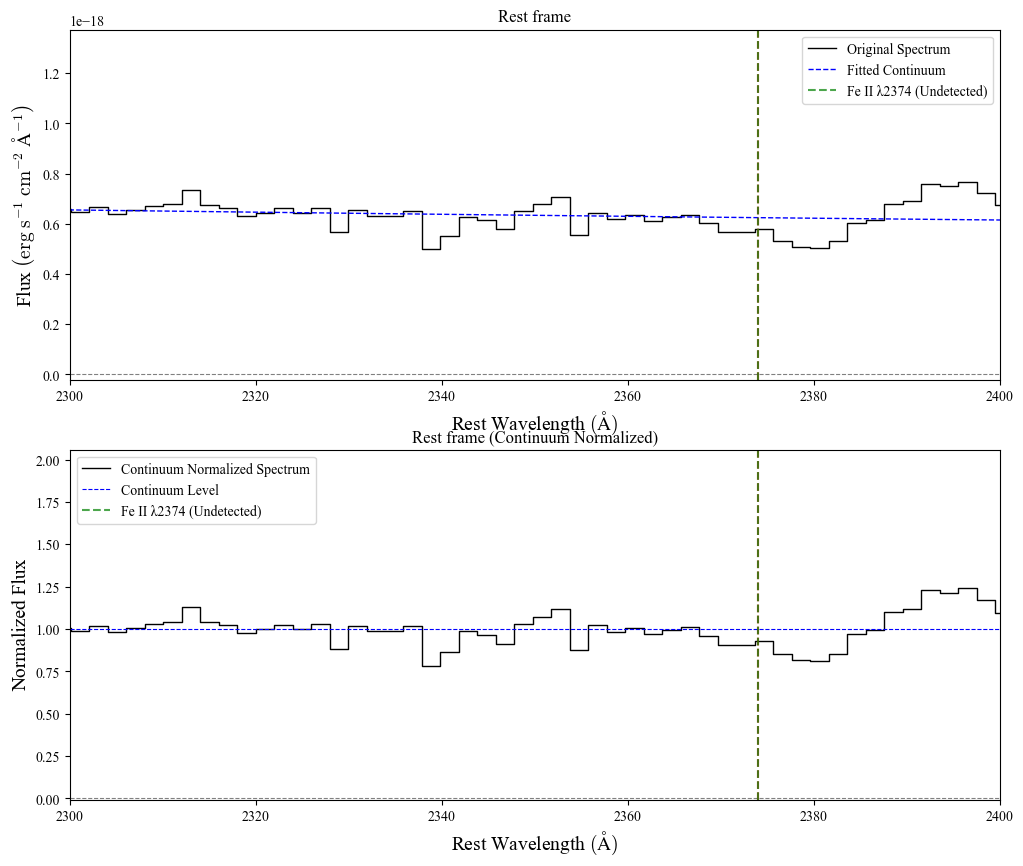

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 10))

# Figure 1
ax[0].step(spec.spectral_axis.value / (1 + spec_redshift), spec.flux.value, 
           where='mid', label='Original Spectrum', color='black', linewidth=1)
ax[0].plot(spec.spectral_axis.value / (1 + spec_redshift), con_flux, 
           label='Fitted Continuum', color='blue', linestyle='--', linewidth=1)
ax[0].axhline(y = 0, color='gray', linestyle='--', linewidth=0.8)

ax[0].set_ylabel(r'Flux $\left(\mathrm{erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}\right)$', fontsize=14)
ax[0].set_xlabel(r'Rest Wavelength $(\mathrm{\AA})$', fontsize=14)

# Figure 2
ax[1].step(spec.spectral_axis.value / (1 + spec_redshift), spec.flux.value / con_flux, 
           where='mid', label='Continuum Normalized Spectrum', color='black', linewidth=1)
ax[1].axhline(y = 0, color='gray', linestyle='--', linewidth=0.8)
ax[1].axhline(y = 1, color='blue', linestyle='--', linewidth=0.8, label = "Continuum Level")

ax[1].set_xlabel(r'Rest Wavelength $(\mathrm{\AA})$', fontsize=14)
ax[1].set_ylabel('Normalized Flux', fontsize=14)

ax[0].set_title("Rest frame")
ax[1].set_title("Rest frame (Continuum Normalized)")

# Detected lines
for line_name, line_center in confirmed_linedict.items():
    for figure_idx in (0, 1):
        ax[figure_idx].axvline(x = line_center / (1 + spec_redshift), color='red', linestyle='--', alpha=0.7)
        ax[figure_idx].text(line_center / (1 + spec_redshift) + 5, 0.8 * np.max(spec.flux.value), line_name, rotation=90, verticalalignment='bottom', fontsize=10)

# Undetected line
ax[0].axvline(x = 2374, color='green', linestyle='--', alpha=0.7, label = "Fe II λ2374 (Undetected)")
ax[1].axvline(x = 2374, color='green', linestyle='--', alpha=0.7, label = "Fe II λ2374 (Undetected)")

ax[0].legend()
ax[1].legend()

# ax[0].set_xlim(2300, 2400)
# ax[1].set_xlim(2300, 2400)

# Absorption wing boundary

In [ ]:
# Function to compute absorption area within wings
def compute_absorption_area(velocity, flux, left_crossing, right_crossing):
    """
    Compute the area between continuum (flux=1) and normalized flux within the absorption wings
    using trapezoidal integration.
    
    Parameters:
    -----------
    velocity : np.ndarray
        Velocity array in km/s
    flux : np.ndarray
        Normalized flux array (continuum is at 1.0)
    left_crossing : float or None
        Left wing boundary velocity
    right_crossing : float or None
        Right wing boundary velocity
    
    Returns:
    --------
    area : float or None
        Integrated area between continuum and flux (absorption strength)
        Units: km/s (velocity integrated flux deficit)
    """
    if left_crossing is None or right_crossing is None:
        return None
    
    # Extract data within the wings
    mask = (velocity >= left_crossing) & (velocity <= right_crossing)
    vel_region = velocity[mask]
    flux_region = flux[mask]
    
    if len(vel_region) < 2:
        return None
    
    # Calculate area: integral of (1 - flux) dv
    # This is the flux deficit below continuum
    flux_deficit = 1.0 - flux_region
    
    # Use trapezoidal integration
    area = np.trapz(flux_deficit, vel_region)
    
    return area

# Function to compute v50 (median velocity)
def compute_v50(velocity, flux, left_crossing, right_crossing):
    """
    Compute the v50 velocity - the velocity at which half of the absorption area 
    has been accumulated when integrating from the left wing.
    
    Parameters:
    -----------
    velocity : np.ndarray
        Velocity array in km/s
    flux : np.ndarray
        Normalized flux array (continuum is at 1.0)
    left_crossing : float or None
        Left wing boundary velocity
    right_crossing : float or None
        Right wing boundary velocity
    
    Returns:
    --------
    v50 : float or None
        Velocity at which half the absorption area is accumulated
        Units: km/s
    """
    if left_crossing is None or right_crossing is None:
        return None
    
    # Extract data within the wings
    mask = (velocity >= left_crossing) & (velocity <= right_crossing)
    vel_region = velocity[mask]
    flux_region = flux[mask]
    
    if len(vel_region) < 2:
        return None
    
    # Calculate flux deficit
    flux_deficit = 1.0 - flux_region
    
    # Compute cumulative area from left to right
    cumulative_area = np.zeros(len(vel_region))
    for i in range(1, len(vel_region)):
        # Trapezoidal rule for each segment
        dv = vel_region[i] - vel_region[i-1]
        avg_deficit = (flux_deficit[i] + flux_deficit[i-1]) / 2.0
        cumulative_area[i] = cumulative_area[i-1] + avg_deficit * dv
    
    # Total area
    total_area = cumulative_area[-1]
    
    if total_area <= 0:
        return None
    
    # Find where cumulative area reaches half
    half_area = total_area / 2.0
    
    # Find the index where we cross half the area
    idx = np.searchsorted(cumulative_area, half_area)
    
    if idx == 0:
        return vel_region[0]
    if idx >= len(vel_region):
        return vel_region[-1]
    
    # Linear interpolation to get precise v50
    v1, v2 = vel_region[idx-1], vel_region[idx]
    a1, a2 = cumulative_area[idx-1], cumulative_area[idx]
    
    if a2 != a1:
        v50 = v1 + (half_area - a1) * (v2 - v1) / (a2 - a1)
    else:
        v50 = v1
    
    return v50

In [66]:
print(confirmed_linedict)

{'Mg II λ2799': 7532.315}



Absorption Analysis Results:
Mg II λ2799         
  Left crossing:   -2053.20 km/s  
  Right crossing:  963.52 km/s    
  Absorption area: 418.38 km/s    
  v50 (median):    -511.83 km/s   
------------------------------------------------------------------------------------------
Fe II λ2374         
  Left crossing:   -863.82 km/s   
  Right crossing:  1602.79 km/s   
  Absorption area: 246.69 km/s    
  v50 (median):    536.56 km/s    
------------------------------------------------------------------------------------------


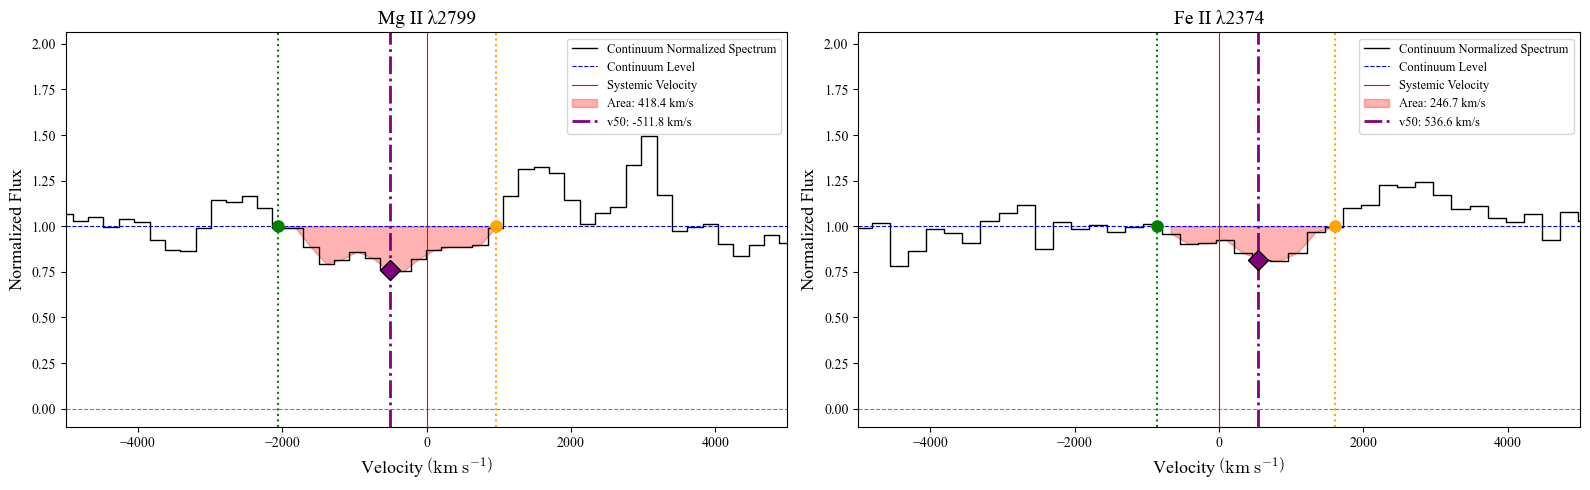

In [ ]:
# Compute absorption areas, v50, and visualize with filled regions

connorm_flux = spec.flux.value / con_flux
spec_norm = Spectrum1D(spectral_axis = spec.spectral_axis, flux = connorm_flux * u_flux)

confirmed_linedict["C II λ1334"] = frequent_lines["C II λ1334"] * (1 + redshift[test_fileindex])  # Manually add this line for visualization

# Store results
absorption_results = {}

# Calculate how many subplots we need
num_lines = len(confirmed_linedict)
if num_lines == 0:
    print("No frequent lines detected for this galaxy.")
else:
    # Create subplots - arrange in 2 columns
    n_cols = 2
    n_rows = (num_lines + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    
    # Flatten axes array for easier iteration
    if num_lines == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot each line
    for idx, (line_name, line_center) in enumerate(confirmed_linedict.items()):
        ax = axes[idx]
        
        # Calculate velocity for this specific line
        central_wavelength = frequent_lines[line_name] * (1 + redshift[test_fileindex])  # In observed frame
        delta_velocity = light_speed.value * (spec_norm.spectral_axis.value / central_wavelength - 1)
        
        # Find zero crossings
        left_cross, right_cross = find_zero_crossings(delta_velocity, spec_norm.flux.value)
        
        # Compute absorption area and v50
        absorption_area = compute_absorption_area(delta_velocity, spec_norm.flux.value, left_cross, right_cross)
        v50 = compute_v50(delta_velocity, spec_norm.flux.value, left_cross, right_cross)
        
        absorption_results[line_name] = {
            'left_crossing': left_cross,
            'right_crossing': right_cross,
            'absorption_area': absorption_area,
            'v50': v50
        }
        
        # Plotting
        ax.step(delta_velocity, spec_norm.flux.value, where='mid', label='Continuum Normalized Spectrum', color='black', linewidth=1)
        ax.axhline(y=1, color='blue', linestyle='--', linewidth=0.8, label="Continuum Level")
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
        ax.axvline(x=0, color='red', linestyle='-', linewidth=0.8, label="Systemic Velocity")
        
        # Fill the absorption region if wings exist
        if left_cross is not None and right_cross is not None:
            # Create mask for the absorption region
            wing_mask = (delta_velocity >= left_cross) & (delta_velocity <= right_cross)
            wing_vel = delta_velocity[wing_mask]
            wing_flux = spec_norm.flux.value[wing_mask]
            
            # Fill between continuum and flux
            ax.fill_between(wing_vel, wing_flux, 1.0, alpha=0.3, color='red', 
                           label=f'Area: {absorption_area:.1f} km/s')
            
            # Mark zero crossings
            ax.axvline(x=left_cross, color='green', linestyle=':', linewidth=1.5)
            ax.plot(left_cross, 1.0, 'go', markersize=8)
            ax.axvline(x=right_cross, color='orange', linestyle=':', linewidth=1.5)
            ax.plot(right_cross, 1.0, 'o', color='orange', markersize=8)
            
            # Mark v50
            if v50 is not None:
                ax.axvline(x=v50, color='purple', linestyle='-.', linewidth=2, label=f'v50: {v50:.1f} km/s')
                # Find flux at v50 for marker placement
                v50_idx = np.argmin(np.abs(delta_velocity - v50))
                v50_flux = spec_norm.flux.value[v50_idx]
                ax.plot(v50, v50_flux, 'D', color='purple', markersize=10, markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlim(-5000, 5000)
        ax.set_xlabel(r'Velocity $\left(\mathrm{km\;s^{-1}}\right)$', fontsize=13)
        ax.set_ylabel('Normalized Flux', fontsize=13)
        ax.set_title(f'{line_name}', fontsize=14)
        ax.legend(fontsize=9, loc='best')
    
    # Hide any unused subplots
    for idx in range(num_lines, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()

# Print results
print("\nAbsorption Analysis Results:")
print("=" * 90)
for line_name, results in absorption_results.items():
    left = results['left_crossing']
    right = results['right_crossing']
    area = results['absorption_area']
    v50 = results['v50']
    
    left_str = f"{left:.2f} km/s" if left is not None else "None"
    right_str = f"{right:.2f} km/s" if right is not None else "None"
    area_str = f"{area:.2f} km/s" if area is not None else "N/A"
    v50_str = f"{v50:.2f} km/s" if v50 is not None else "N/A"
    
    print(f"{line_name:20s}")
    print(f"  Left crossing:   {left_str:15s}")
    print(f"  Right crossing:  {right_str:15s}")
    print(f"  Absorption area: {area_str:15s}")
    print(f"  v50 (median):    {v50_str:15s}")
    print("-" * 90)

plt.savefig("Absorption_Area_v50_FrequentLines.png", dpi=300)

In [ ]:
print(absorption_results)

# -500 km/s 

{'Mg II λ2799': {'left_crossing': -1855.1242371204685, 'right_crossing': 296.6226997788649, 'absorption_area': 428.8799723400854, 'v50': -780.4625266706166}, 'Fe II λ2374': {'left_crossing': -2250.9917367496014, 'right_crossing': 1205.4779948353935, 'absorption_area': 476.08753079077803, 'v50': -383.83685519353924}}
